In [156]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

In [89]:
data = pd.read_csv("employee_attrition_train.csv")

In [ ]:
data.head(3)

In [91]:
data_mod = data.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours", "JobRole", "EducationField", "Department"])
data_mod.loc[data_mod.Attrition == "No", "Attrition"] = 0
data_mod.loc[data_mod.Attrition == "Yes", "Attrition"] = 1

In [92]:
y = data_mod.Attrition
x = data_mod.drop(columns=["Attrition"])
cat_cols = x.select_dtypes("object").columns
num_cols = x.select_dtypes(["int64", "float64"]).columns

In [93]:
y = y.astype("int64")

In [97]:
cat_transformed = pd.get_dummies(x[cat_cols])
num_transformed = pd.DataFrame(StandardScaler().fit_transform(x[num_cols]), columns=num_cols)

In [98]:
x_transformed = pd.concat([cat_transformed, num_transformed], axis=1)

In [99]:
x_transformed = x_transformed.fillna(0)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(x_transformed, y)

In [ ]:
y_train.value_counts()

0.8178403755868544
Best Parameters RandomForestClassifier(max_depth=5, min_samples_split=6, n_estimators=50)
Roc-Auc Score 0.8178403755868544
0.7425143453312467
Best Parameters KNeighborsClassifier(n_neighbors=26, weights='distance')
Roc-Auc Score 0.7425143453312467
0.7739175795513823
Best Parameters DecisionTreeClassifier(max_depth=4)
Roc-Auc Score 0.7739175795513823
0.8472613458528951
Best Parameters LogisticRegression(solver='liblinear')
Roc-Auc Score 0.8472613458528951


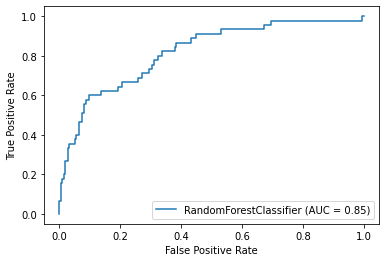

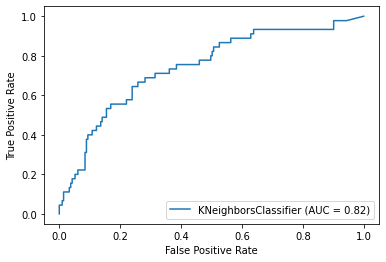

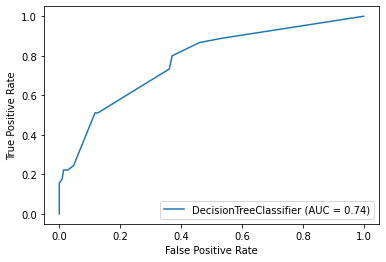

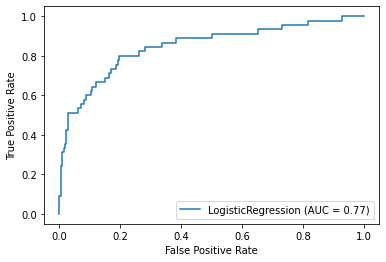

In [178]:
log_reg = LogisticRegression(solver="liblinear")
rf = RandomForestClassifier()
k_neighbors = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
perceptron = Perceptron()

log_reg_params = {"penalty": ["l1", "l2"]}

decision_tree_params = {"max_depth": [2,3,4]}

rf_params = {"n_estimators":[50, 100, 150], 
             "max_depth": range(2,6),
             "min_samples_split": [2,4,6]}

k_neighbors_params = {"n_neighbors": range(3,30),
                      "weights": ["uniform","distance"]}

perceptron_params = {"penalty": ["l1", "l2"]}

def evaluate(estimator, params):
    cv = GridSearchCV(estimator=estimator,
                      cv=3,
                      param_grid=params,
                      scoring="roc_auc").fit(X_train, y_train)
    
    print(cv.score(X_test, y_test))
    
    # give back the probability for label 1 
    prob_one = [i[1] for i in cv.predict_proba(X_test)]
    
    # get the false postitive and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, prob_one)
    
    name = str(estimator).split("(")[0]
    
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=name)
    display.plot()
    
    
    return cv, fpr, tpr
    
eval_params = [(rf, rf_params), 
               (k_neighbors, k_neighbors_params),
               (decision_tree, decision_tree_params),
               (log_reg, log_reg_params)]  

# fig, axs = plt.subplots(1, 3, figsize=(18,6))
# fig.patch.set_facecolor('white')


for i, (est, params) in enumerate(eval_params):
    cv, fpr, tpr = evaluate(est, params)

    roc_auc = auc(fpr, tpr)    
    # axs[i].plot(fpr, tpr)
    # 
    # axs[i].title.set_text("Model:" + str(est) + " AUC: " + str(round(roc_auc, 3)))
    
    print("Best Parameters", cv.best_estimator_)
    print("Roc-Auc Score", roc_auc)